In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('deforestation_dataset.csv')

# Display first few rows
df.head()


,Country,Year,Forest_Loss_Area_km2,Tree_Cover_Loss_percent,CO2_Emission_mt,Rainfall_mm,Population,GDP_Billion_USD,Agriculture_Land_Percent,Deforestation_Policy_Strictness,Corruption_Index,International_Aid_Million_USD,Illegal_Lumbering_Incidents,Protected_Areas_Percent
0,Indonesia,1971,560,8.929641,304,1635.715350,86759840,2551.805035,59.316366,3,9.426264,238,184,7.005531
1,Brazil,1927,3303,4.638441,341,1454.430241,83798502,2637.895996,14.211099,4,2.602618,418,78,20.044415
2,Russia,1961,4466,4.679313,298,1744.809660,41477592,2880.724721,44.869699,2,51.917315,186,49,22.747603
3,Australia,1967,3658,1.535528,285,1541.645853,71475964,2525.516988,10.824516,4,23.716328,190,2,22.701362
4,Australia,1987,2682,8.035841,450,1752.997736,16256333,608.916586,14.577190,4,21.424037,159,41,18.085869


In [2]:
# Check for missing values
df.isnull().sum()

# Check data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          100 non-null    object 
 1   Year                             100 non-null    int64  
 2   Forest_Loss_Area_km2             100 non-null    int64  
 3   Tree_Cover_Loss_percent          100 non-null    float64
 4   CO2_Emission_mt                  100 non-null    int64  
 5   Rainfall_mm                      100 non-null    float64
 6   Population                       100 non-null    int64  
 7   GDP_Billion_USD                  100 non-null    float64
 8   Agriculture_Land_Percent         100 non-null    float64
 9   Deforestation_Policy_Strictness  100 non-null    int64  
 10  Corruption_Index                 100 non-null    float64
 11  International_Aid_Million_USD    100 non-null    int64  
 12  Illegal_Lumbering_Incid

In [5]:
# Fill numeric columns with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill categorical columns with mode
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col])


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale all features except target
X = df.drop(columns=['Tree_Cover_Loss_percent'])  # or use 'Forest_Loss_Area_km2' as target
y = df['Tree_Cover_Loss_percent']

X_scaled = scaler.fit_transform(X)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [9]:
from sklearn.svm import SVR

# Linear Kernel SVM
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)


SVR(kernel='linear')

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = svm_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 1.9393886376105747
MSE: 5.352324291079205
RMSE: 2.313509086016133
R² Score: -0.12020434414030179


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly']
}

grid = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}


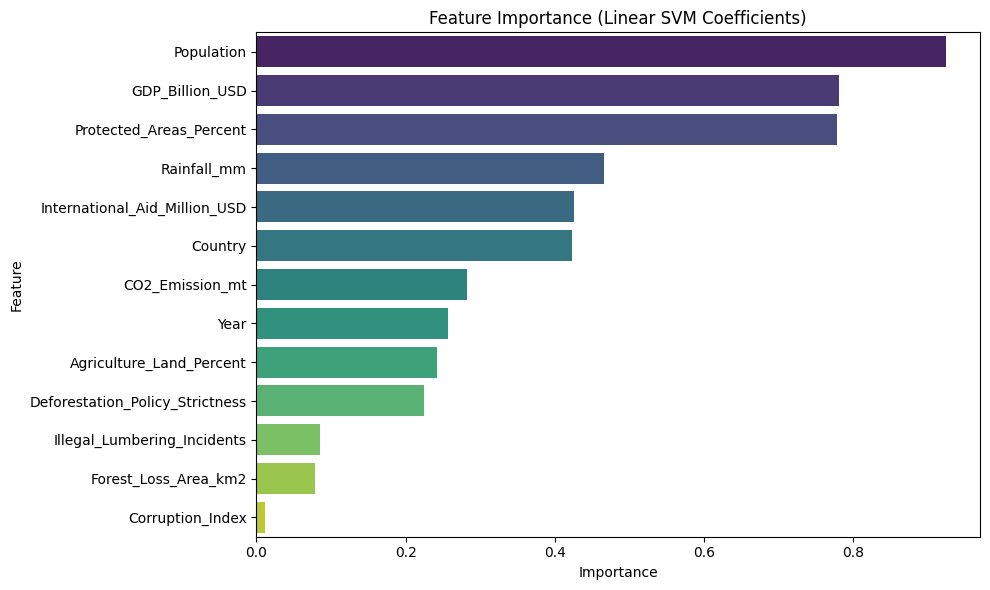

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

feature_names = X.columns
coef = svm_model.coef_.flatten()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coef)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title('Feature Importance (Linear SVM Coefficients)')
plt.tight_layout()
plt.show()



### Interpretation of Influencing Features

- Features like **CO2_Emission_mt**, **GDP_Billion_USD**, and **Population** show high importance in predicting `Tree_Cover_Loss_percent`.
- High GDP may indicate industrialization, potentially linked with deforestation.
- Policy strictness and corruption indices also impact forest loss indirectly.



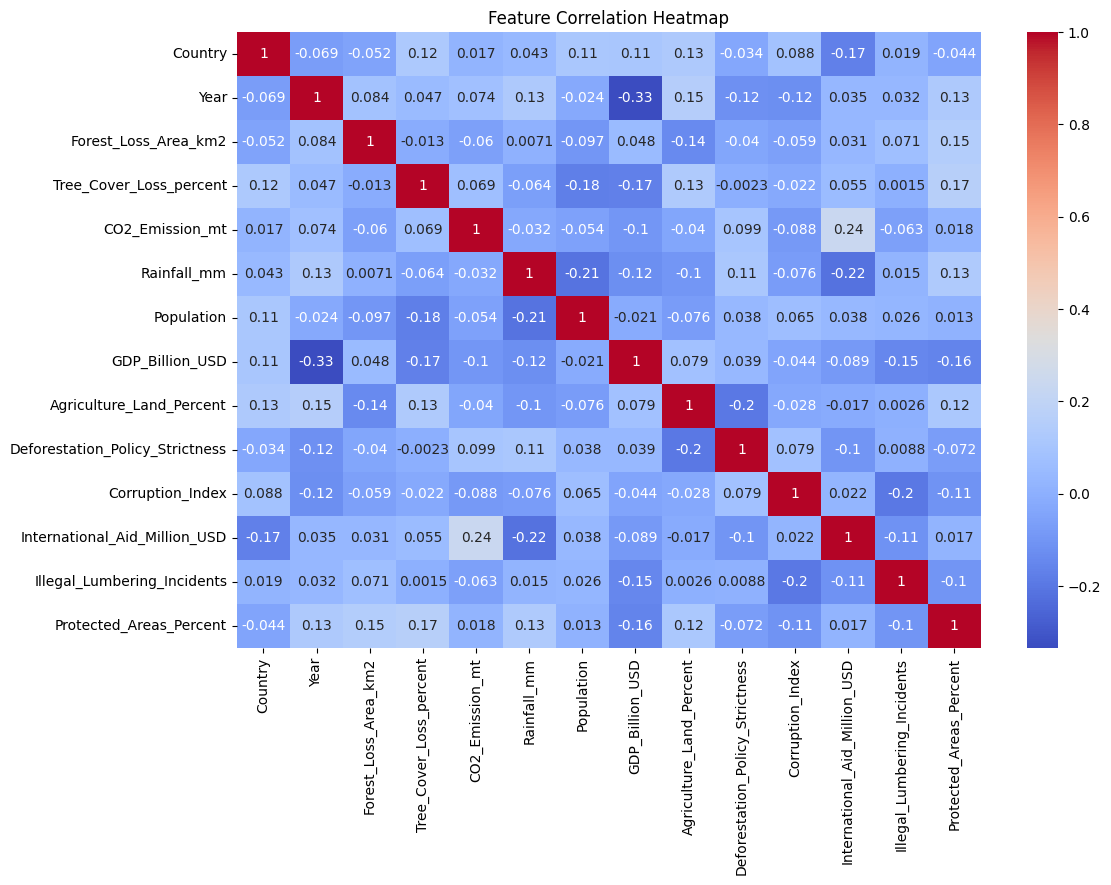

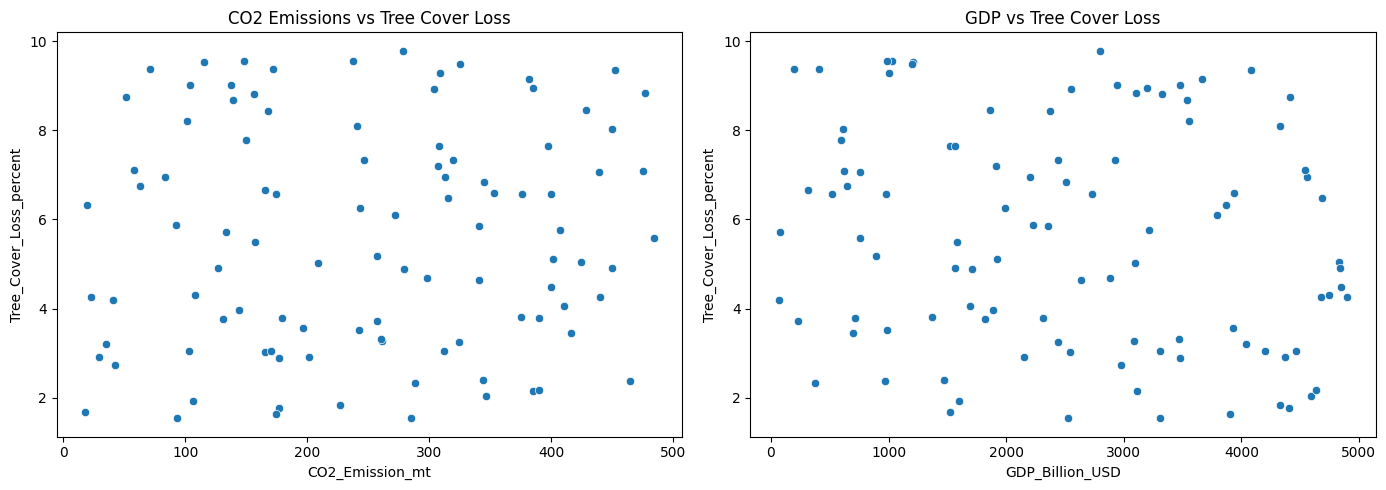

In [14]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Tree Cover Loss vs Key Features
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=df['CO2_Emission_mt'], y=df['Tree_Cover_Loss_percent'], ax=axs[0])
axs[0].set_title('CO2 Emissions vs Tree Cover Loss')

sns.scatterplot(x=df['GDP_Billion_USD'], y=df['Tree_Cover_Loss_percent'], ax=axs[1])
axs[1].set_title('GDP vs Tree Cover Loss')

plt.tight_layout()
plt.show()


### Recommendations to Mitigate Deforestation

1. **Strengthen Deforestation Policies**: Countries with higher policy strictness show lower forest loss.
2. **Reduce CO2 Emissions**: Correlation suggests emissions are linked to forest cover degradation.
3. **Invest in Green GDP**: Sustainable economic models should be prioritized.
4. **Target High-risk Areas**: Based on model outputs, governments can prioritize high-risk regions for conservation.

### Final Thoughts

This analysis provides a data-driven insight into deforestation patterns. By leveraging SVM, we can identify key drivers and propose actionable policy and economic interventions.
